# **Doc2Vec Logistic Regression**  
Wengie Wang

In [0]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim

import nltk
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup


In [0]:
RANDOM_SEED = 123
DEVICE = "cuda"
ly = pd.read_csv("4_19_lyrics_with_tags.csv", delimiter = ",", dtype = {'lyrics':str})


# take out lyrics
lyrics = ly['lyrics']

In [0]:
import nltk
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;|\n]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
lyrics = lyrics.apply(clean_text)
ly["lyrics"]=lyrics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
import gensim
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled
  
X_train, X_test, y_train, y_test = train_test_split(ly.lyrics, ly.tags, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test
#view raw


In [0]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 77885/77885 [00:00<00:00, 2335566.62it/s]


In [0]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5, class_weight="balanced")
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [0]:
my_tags = ["rock", "pop","indie", "dance","alternative","others"]
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))


accuracy 0.6372507061542412
              precision    recall  f1-score   support

        rock       0.05      0.03      0.04       643
         pop       0.09      0.27      0.13       497
       indie       0.12      0.15      0.13       948
       dance       0.08      0.03      0.04       944
 alternative       0.29      0.20      0.24      2943
      others       0.78      0.80      0.79     17391

   micro avg       0.64      0.64      0.64     23366
   macro avg       0.24      0.25      0.23     23366
weighted avg       0.63      0.64      0.63     23366



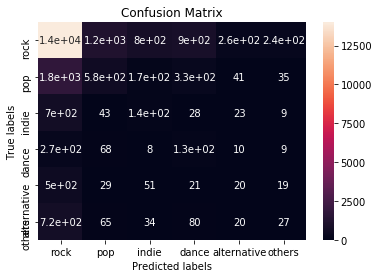

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt 

cm = confusion_matrix(y_test, y_pred, my_tags)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells


# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(my_tags); ax.yaxis.set_ticklabels(my_tags);